In [1]:
import numpy as np
from PIL import Image
import neural as nn
import matplotlib.pyplot as plt
import os

In [2]:
def get_data_from_directory(path, target_size=(32, 32)):
    imgs_file = os.listdir(path)
    m = len(imgs_file)
    
    x = np.zeros(shape=(m, target_size[0], target_size[1], 1))
    y = np.zeros(shape=(m,))
    
    for ind, img in enumerate(imgs_file):
        img_path = path + img
        x[ind] = np.expand_dims(np.array(Image.open(img_path).resize(target_size)), axis=-1)
        y[ind] = int(img[img.rindex("_")+1:-4]) - 1
        
    return x, y

In [3]:
x_train, y_train = get_data_from_directory("train/")
x_test, y_test = get_data_from_directory("test/")

In [4]:
arabic_letters = [
    "أ",
    "ب",
    "ت",
    "ث",
    "ج",
    "ح",
    "خ",
    "د",
    "ذ",
    "ر",
    "ز",
    "س",
    "ش",
    "ص",
    "ض",
    "ط",
    "ظ",
    "ع",
    "غ",
    "ف",
    "ق",
    "ك",
    "ل",
    "م",
    "ن",
    "ه",
    "و",
    "ي",
]
len(arabic_letters)

28

In [5]:
def display_samples(img_samples, labels, arabic_letters):
    f, ax = plt.subplots(3, 3)
    cntr = 0
    for row in range(3):
        for col in range(3):
            ax[row, col].imshow(img_samples[cntr])
            ax[row, col].axis("off")
            ax[row, col].set_title(arabic_letters[int(labels[cntr])])
            cntr += 1

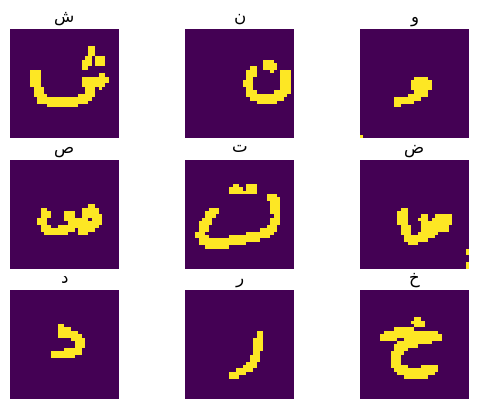

In [6]:
rndm_ind = np.random.permutation(x_test.shape[0])
display_samples(x_test[rndm_ind], y_test[rndm_ind], arabic_letters)

In [7]:
y_train = nn.preprocessing.to_one_hot(y_train)
y_test = nn.preprocessing.to_one_hot(y_test)

In [8]:
x_train /= 255.0
x_test /= 255.0

In [25]:
model = nn.Sequential([
    nn.layers.Conv2D(4, 3, kernel_initializer="he_normal"), # (30, 30, 4)
    nn.layers.Activation("leaky_relu"), # (30, 30, 4)
    nn.layers.MaxPooling2D(), # (15, 15, 4)
    nn.layers.Conv2D(8, 3, kernel_initializer="he_normal"), # (13, 13, 8)
    nn.layers.Activation("leaky_relu"), # (13, 13, 8)
    nn.layers.MaxPooling2D(filter_size=3, strides=2), # (6, 6, 8)
    nn.layers.Conv2D(16, 3, kernel_initializer="he_normal"), # (4, 4, 16)
    nn.layers.Activation("leaky_relu"), # (4, 4, 16)
    nn.layers.MaxPooling2D(), # (2, 2, 16)
    nn.layers.Flatten(),
    nn.layers.FullyConnected(neurons=64, kernel_initializer="he_normal"),
    nn.layers.Activation("leaky_relu"),
    nn.layers.Dropout(0.2),
    nn.layers.FullyConnected(neurons=32, kernel_initializer="he_normal"),
    nn.layers.Activation("leaky_relu"),
    nn.layers.FullyConnected(neurons=28, kernel_initializer="xavier_normal"),    
])

In [50]:
model.set(
    loss=nn.losses.OneHotCrossEntropy(from_logits=True),
    optimizer=nn.optimizers.Adam(lr=0.00001),
    metrics=["one_hot_acc"]
)

In [51]:
history = model.train(x_train, y_train, epochs=50)

Epoch 1/50:  421/421: oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo	loss: 0.37068	one_hot_acc: 0.87210
Epoch 2/50:  156/421: oooooooooooooooooooooo......................................	loss: 0.38604	one_hot_acc: 0.86839

KeyboardInterrupt: 

In [ ]:
plt.plot(history["loss"])

In [ ]:
plt.plot(history["one_hot_acc"])

In [52]:
model.evaluate(x_test, y_test, batch_size=128)

27/27: oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


{'loss': 0.4552049627351387, 'one_hot_acc': 0.85}

In [72]:
def display_trained_samples(img_samples, labels, predictions, arabic_letters):
    f, ax = plt.subplots(3, 3)
    f.tight_layout()
    cntr = 0
    for row in range(3):
        for col in range(3):
            ax[row, col].imshow(img_samples[cntr])
            ax[row, col].axis("off")
            ax[row, col].set_title(f"Label: {arabic_letters[int(labels[cntr])]}\nPred: {arabic_letters[int(predictions[cntr])]}")
            cntr += 1

1/1: oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


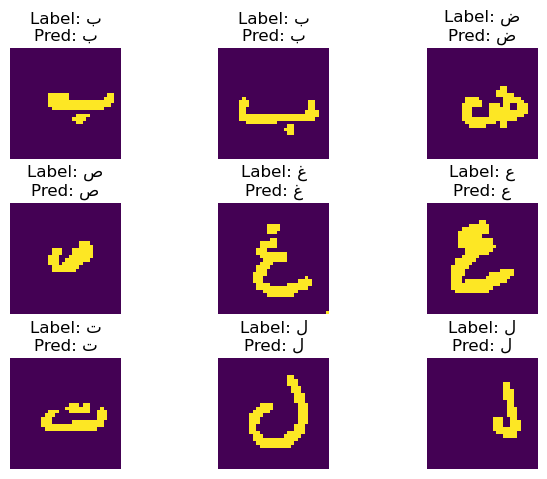

In [103]:
rndm_idx = np.random.choice(x_test.shape[0], 9, replace=False)
pred = np.argmax(model.predict(x_test[rndm_idx]), axis=-1)
lbls = np.argmax(y_test[rndm_idx], axis=-1)
display_trained_samples(x_test[rndm_idx], lbls, pred, arabic_letters)

In [94]:
lyr_num = 0
for lyr in model.layers:
    if lyr.get_base() == nn.layers.StdLayer:
        path_name = "Arabic_MNIST_Weights/" + "layer" + str(lyr_num)
        kernel = lyr.kernel
        bias = lyr.bias
        kernel_path_name = path_name + "_kernel.npy"
        bias_path_name = path_name + "_bias.npy"
        np.save(kernel_path_name, kernel)
        np.save(bias_path_name, bias)
        lyr_num += 1
    else:
        pass